In [1]:
import sys
import json

import numpy as np
import matplotlib.pyplot as plt

from io import StringIO
from numba import jit

from typing import Tuple

# Testing the logic

## Set up the arrays to use for storing and analyzing data

Note that the arrays get quite large, so make sure you have enough RAM

In [8]:
num_markets = 12001
num_data_points = 100000

volume = np.empty((num_markets * num_data_points), dtype=np.float64) * np.nan
price = np.empty((num_markets * num_data_points), dtype=np.float32) * np.nan
volume_price_product = np.empty((num_markets * num_data_points), dtype=np.float64) * np.nan
is_buy = np.empty((num_markets * num_data_points), dtype=float) * np.nan

market_analysis = np.zeros((num_markets, 5), dtype=np.float64)

## Use the numby JIT compiler for core analysis
Roughly 10x speedup over vanilla numpy

In [9]:
@jit(nopython=True)
def analyze_data(
    idx: int, 
    market: int, 
    volume: np.ndarray, 
    price: np.ndarray, 
    volume_price_product: np.ndarray, 
    is_buy: np.ndarray, 
    market_analysis: np.ndarray
):
    start_pos_idx = market * num_data_points
    end_pos_idx = market * num_data_points + idx + 1
    
    # Total volume
    market_analysis[market, 0] = np.nansum(volume[start_pos_idx:end_pos_idx])
    # Mean price
    market_analysis[market, 1] = np.nanmean(price[start_pos_idx:end_pos_idx])
    # Mean volume
    market_analysis[market, 2] = np.nanmean(volume[start_pos_idx:end_pos_idx])
    # Volume weighted price mean
    market_analysis[market, 3] = np.nanmean(volume_price_product[start_pos_idx:end_pos_idx])
    # Percentage buys
    not_nan = is_buy[start_pos_idx:end_pos_idx][np.isnan(is_buy[start_pos_idx:end_pos_idx]) == False]
    if not_nan.size > 0:
        market_analysis[market, 4] = np.count_nonzero(not_nan) / not_nan.size

analyze_data(0, 0, volume, price, volume_price_product, is_buy, market_analysis)

## Extract data from the json

In [10]:
def get_data(line: dict) -> Tuple[int, int, np.ndarray]:
    idx = line["id"]
    market = line["market"]
    position_idx = market * num_data_points + idx
    
    volume[position_idx] = line["volume"]
    price[position_idx] = line["price"]
    volume_price_product[position_idx] = line["volume"] * line["price"]
    is_buy[position_idx] = line["is_buy"]
    return idx, market, volume, price, volume_price_product, is_buy

## Simulated stdin

In [27]:
sys.stdin = StringIO('{"id":100000,"market":5773,"price":1.234,"volume":1234.56,"is_buy":true}')
idx, market, volume, price, volume_price_product, is_buy = get_data(line=json.loads(sys.stdin.readline()))

### Time the code execution

In [28]:
%%timeit
analyze_data(
    idx=idx, 
    market=market, 
    volume=volume, 
    price=price, 
    volume_price_product=volume_price_product, 
    is_buy=is_buy, 
    market_analysis=market_analysis
)

721 µs ± 3.02 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Variation of analysis time with id
Data shown on a log-log plot

Limitations
- The additional elements are just NaNs, not actual float -> this is the minimum analysis time

In [29]:
ids = [1, 10, 100, 1000, 10000, 100000]
analysis_time = [607e-9, 641e-9, 1.13e-6, 7.64e-6, 72.6e-6, 721e-6]

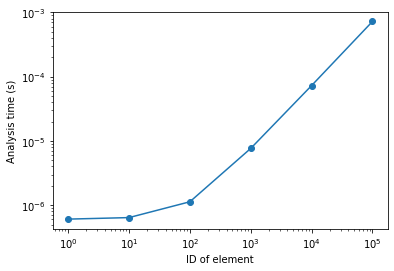

In [30]:
fig, ax = plt.subplots()
ax.plot(ids, analysis_time, "o-")
ax.set_xlabel("ID of element")
ax.set_ylabel("Analysis time (s)")

ax.set_yscale("log")
ax.set_xscale("log")
plt.savefig("variation_analysis_time_with_id.jpg", dpi=300)